# TSOSI: Coverage of ROR and Wikidata identifiers for supporters

In [1]:
import pandas as pd, requests, random

In [2]:
raw_json = requests.get("https://tsosi.org/api/entities/all?format=json").json()

In [3]:
## nb of items within the json
len(raw_json)

1026

In [4]:
random.choice(raw_json)

{'id': '7844a40b-4360-4f13-97f3-31746db641e6',
 'name': 'Bond University Library',
 'short_name': None,
 'country': 'AU',
 'identifiers': [],
 'coordinates': None,
 'logo': None,
 'icon': None,
 'is_recipient': False,
 'is_partner': False}

In [5]:
## flatten all entities
for item in raw_json : 
    if item.get("identifiers") :
        for ids in item["identifiers"] : 
            if ids["registry"] == "ror" : 
                item["ror_id"] = ids["value"]
            if ids["registry"] == "wikidata" : 
                item["wiki_id"] = ids["value"]
                

In [6]:
random.choice(raw_json)

{'id': '8942b39d-c621-4dff-aaa3-7da67e60b10e',
 'name': "Institut des Sciences de l'Evolution de Montpellier",
 'short_name': None,
 'country': 'FR',
 'identifiers': [{'registry': 'ror', 'value': '01cah1n37'}],
 'coordinates': 'POINT(3.87635 43.61093)',
 'logo': None,
 'icon': None,
 'is_recipient': False,
 'is_partner': False,
 'ror_id': '01cah1n37'}

In [7]:
df_raw  = pd.json_normalize(raw_json)
# remove cell where is_receipient = True
df = df_raw[ df_raw["is_recipient"] == False].copy()
# remove columns related to infra
df.drop(columns=['id', "icon", "short_name", "identifiers"], inplace=True)
df.sample(3)

,name,country,coordinates,logo,is_recipient,is_partner,wiki_id,ror_id
624,Technical University of Munich,DE,POINT(11.57549 48.13743),https://tsosi.org/media/4f11bb89-4a03-49df-878...,False,False,Q157808,02kkvpp62
600,Springer Nature (Germany),DE,POINT(13.41053 52.52437),https://tsosi.org/media/b4cd2d9f-53e4-419a-949...,False,False,Q21096327,0117jxy09
217,ETH Zurich,CH,POINT(8.55 47.36667),https://tsosi.org/media/3592824a-6e88-4913-949...,False,False,Q11942,05a28rw58


In [8]:
## add a columns to know if entity has no id
df["has_id"] = (df["ror_id"].notna() | df["wiki_id"].notna())
print(f"nb entities without ror & wikidata id {len(df[ df['has_id'] ==False])} ")

nb entities without ror & wikidata id 51 


## Produce graph coverage of ROR and wikidata identifiers

In [37]:
entity_stats = {
    "Wikidata id" : len(df[ df["wiki_id"].notna()]),
    "ROR id" : len(df[ df["ror_id"].notna()] ),
    "ROR\nand\nWikidata id" : len( df[ df["ror_id"].notna() & df["wiki_id"].notna()] ),
    "with logo" : len(df[ df["logo"].notna()] ),
   # "Without logo\n&\nwith wikidata" : len( df[ df["logo"].isna() & df["wiki_id"].notna()] ),
    "Without ids" : len( df[ df["has_id"] == False] )
}

In [38]:
dfstat = pd.DataFrame.from_dict(entity_stats, orient='index', columns=['count']).reset_index()

In [39]:
import matplotlib.pyplot as plt, datetime

In [40]:
## get metadata
date_raw = datetime.date.today()
date_txt = date_raw.strftime("%Y-%m-%d")
nb_supporters = len(df)

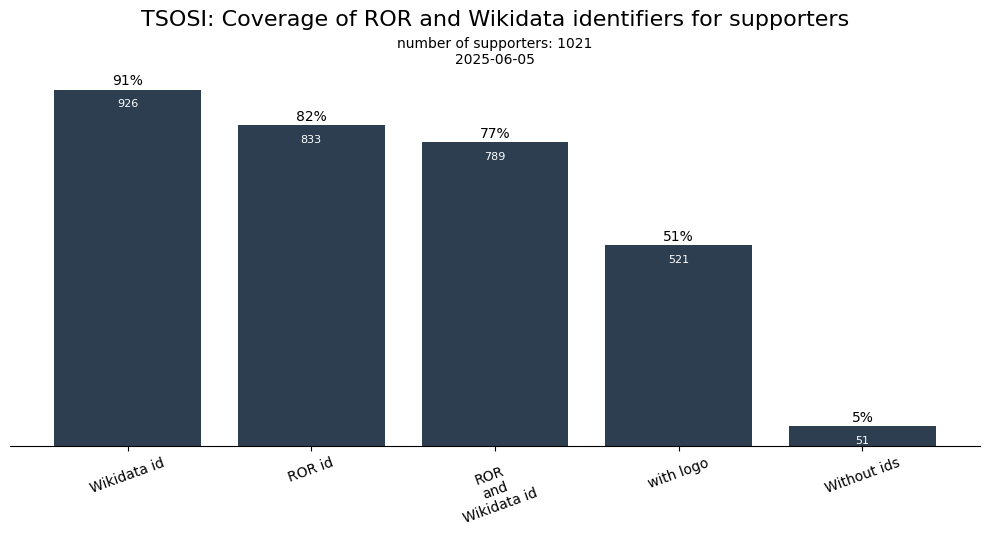

In [52]:
plt.figure(figsize=(10, 6))
plt.bar(dfstat['index'], dfstat['count'])

# Add title and labels
plt.title('TSOSI: Coverage of ROR and Wikidata identifiers for supporters', fontsize = 16, y = 1.1)
plt.suptitle(f"number of supporters: {nb_supporters}\n{date_txt}", fontsize=10, y=0.84)

# Despine the plot
ax = plt.gca()  # Get the current axes
for spine in ax.spines.values():
    spine.set_visible(False)  # Hide all spines
ax.spines['bottom'].set_visible(True)  # Show bottom spine

# Remove left ticks and labels
ax.yaxis.set_ticks([])  # Remove y-axis ticks
ax.yaxis.set_ticklabels([])  # Remove y-axis tick labels

# Add text labels inside the bars
for bar in plt.bar(dfstat['index'], dfstat['count'], color='#2c3e50'):
    yval = bar.get_height()  # Get the height of the bar
    percentage = (yval / nb_supporters) * 100 
    plt.text(bar.get_x() + bar.get_width() / 2, yval -50,  int(yval), 
             ha='center', va='bottom', fontsize = 8, color='white')  # Add text at the center of the bar*
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 40, f'{percentage:.0f}%', 
             ha='center', va='top', color='black')  


plt.xticks(rotation=20)  # Rotate x-axis labels for better readability
plt.tight_layout()
# plt.savefig(f"{date_txt}-tsosi-supporters-id-coverage.png")